In [1]:
# Load Packages
import pandas as pd
import numpy as np
import random
import wfdb
import ast
import tensorflow as tf
from tensorflow.keras import layers, models
import warnings
#used to supress the tf version warning. 
warnings.filterwarnings("ignore", category=UserWarning) 

import os
import matplotlib.pyplot as plt

2024-04-16 17:42:08.803826: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-16 17:42:10.269648: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 17:42:10.269679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 17:42:10.412522: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-16 17:42:10.768057: I tensorflow/core/platform/cpu_feature_guar

In [2]:

def load_raw_data(df, sampling_rate, path):
    """Load raw data from the dataset with desired sampling rate

    """
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [3]:
# Define path for loading data and sampling rate
path = "/home/zfenton/my_project/ml_project/path/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/"
sampling_rate = 100

In [4]:
# Load the labels and convert them to a more readable format

Y = pd.read_csv(path + "ptbxl_database.csv", index_col="ecg_id")
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [5]:
# Load raw data
X = load_raw_data(Y, sampling_rate, path)

# Check the shape of the data
X.shape

In [6]:
# Define variables for loading an example record
record = wfdb.rdrecord(path+'records500/00000/00001_hr', sampto=500)
annotation = wfdb.rdann(path+'scp_statements', 'csv', sampto=100, shift_samps=True)

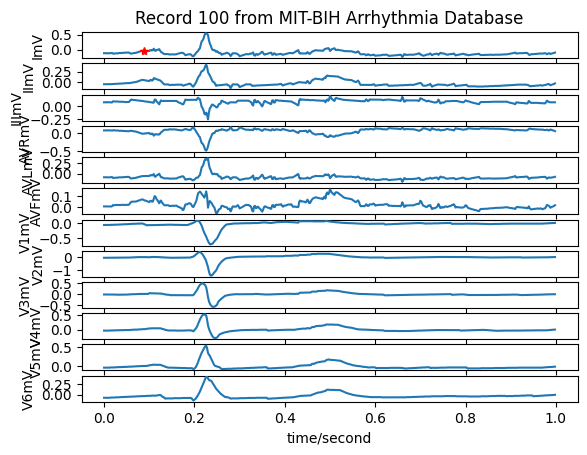

In [7]:
# Using the WFDB package, plot the record.
wfdb.plot_wfdb(record=record, annotation=annotation, title='Record 100 from MIT-BIH Arrhythmia Database')

In [9]:
# Read in the scp_statements.csv file
agg_df = pd.read_csv(path + "scp_statements.csv", index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    """Convert the dictionary of diagnostic classes into a list of aggregated diagnostic classes
    """
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [10]:
# Apply the function to our dataset
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
Y['diagnostic_superclass'] = Y['diagnostic_superclass'].apply(lambda x: x[0] if len(x) > 0 else 'NORM')

# Check the distribution of the diagnostic superclass
Y['diagnostic_superclass'].value_counts()

NORM    9925
MI      5465
STTC    3454
CD      1989
HYP      966
Name: diagnostic_superclass, dtype: int64

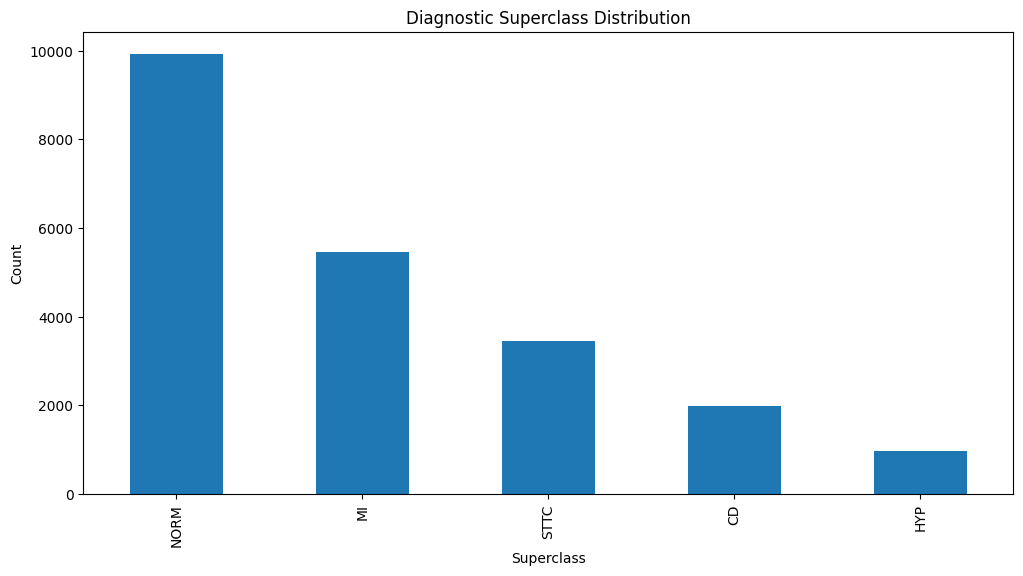

NORM    45.529611
MI      25.069957
STTC    15.844764
CD       9.124272
HYP      4.431396
Name: diagnostic_superclass, dtype: float64


In [12]:
# Plot the distribution of the classes
plt.figure(figsize=(12,6))
Y['diagnostic_superclass'].value_counts().plot(kind='bar')
plt.title('Diagnostic Superclass Distribution')
plt.xlabel('Superclass')
plt.ylabel('Count')
plt.show()

# Calculate the percentage of each class
print(Y['diagnostic_superclass'].value_counts(normalize=True) * 100)



In [13]:
# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

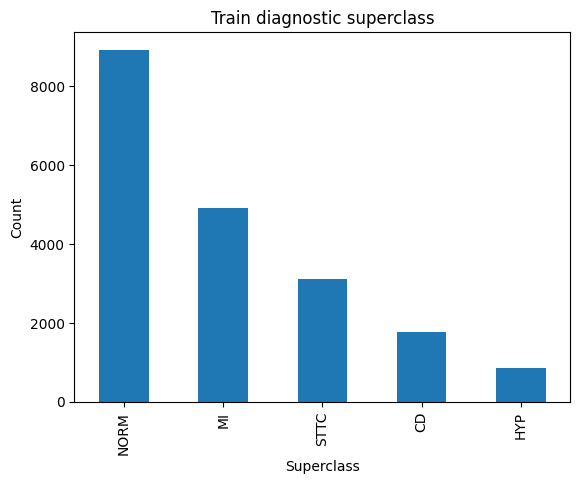

In [15]:
# Visualize the distribution of the train set
y_train.value_counts().plot(kind='bar')
plt.title("Train diagnostic superclass")
plt.xlabel("Superclass")
plt.ylabel("Count")
plt.show()

In [16]:
# Baseline model
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Create a dummy classifier
dummy = DummyClassifier(strategy='most_frequent')

# Train the classifier
dummy.fit(X_train, y_train)

# Predict the labels
y_pred = dummy.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")



Accuracy: 45.63%


### Baseline:

A baseline model where we predict that all EKG readings are normal. 

Baseline Accuracy: 45.63%

In [25]:
# One hot encoding of the target variable
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_test = mlb.transform(y_test)

y_train[0]


array([0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0])

In [27]:
# Split data into train and validation
from sklearn.model_selection import train_test_split
X_train_re, X_val_re, y_train_re, y_val_re = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [29]:
def normalize(data):
    """Normalize the data
    """
    data_mean = data.mean()
    data_sd = data.std()
    return (data - data_mean) / data_sd

X_train_re = normalize(X_train_re)
X_val_re = normalize(X_val_re)
X_test = normalize(X_test)

In [30]:
# Reshape data a labels to be the same shape
X_train_re = X_train_re.reshape(len(X_train_re), 1000, 12)
X_val_re = X_val_re.reshape(len(X_val_re), 1000, 12)
X_test = X_test.reshape(len(X_test), 1000, 12)

X_train_re.shape, X_val_re.shape, X_test.shape, y_train_re.shape, y_val_re.shape, y_test.shape

((17640, 1000, 12),
 (1961, 1000, 12),
 (2198, 1000, 12),
 (17640, 12),
 (1961, 12),
 (2198, 12))

In [32]:
# Build the model
tf.keras.backend.clear_session()
# Set the seed for random number generation for reproducibility
tf.random.set_seed(33)
model = models.Sequential()
model.add(layers.Conv1D(64, 3, activation='relu', input_shape=(1000, 12)))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(128, 3, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Conv1D(256, 3, activation='relu'))
# add average pooling layer
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation='softmax'))



model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 998, 64)           2368      
                                                                 
 max_pooling1d (MaxPooling1  (None, 499, 64)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 497, 128)          24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 248, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 246, 256)          98560     
                                                                 
 global_average_pooling1d (  (None, 256)               0

Epoch 1/10


2024-04-16 17:55:47.963315: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 17:55:53.538031: I external/local_xla/xla/service/service.cc:168] XLA service 0x6feef440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-16 17:55:53.538063: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-04-16 17:55:53.841351: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1713315354.315597    7746 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


552/552 [==============================] - 20s 12ms/step - loss: 19670518571466752.0000 - accuracy: 0.1754 - val_loss: 225471712727138304.0000 - val_accuracy: 0.4630
Epoch 2/10
552/552 [==============================] - 4s 8ms/step - loss: nan - accuracy: 0.2107 - val_loss: nan - val_accuracy: 0.2387
Epoch 3/10
552/552 [==============================] - 4s 8ms/step - loss: nan - accuracy: 0.2512 - val_loss: nan - val_accuracy: 0.2387
Epoch 4/10
552/552 [==============================] - 4s 8ms/step - loss: nan - accuracy: 0.2512 - val_loss: nan - val_accuracy: 0.2387
Epoch 5/10
552/552 [==============================] - 4s 8ms/step - loss: nan - accuracy: 0.2512 - val_loss: nan - val_accuracy: 0.2387
Epoch 6/10
552/552 [==============================] - 4s 8ms/step - loss: nan - accuracy: 0.2512 - val_loss: nan - val_accuracy: 0.2387
Epoch 7/10
552/552 [==============================] - 4s 8ms/step - loss: nan - accuracy: 0.2512 - val_loss: nan - val_accuracy: 0.2387
Epoch 8/10
552/552

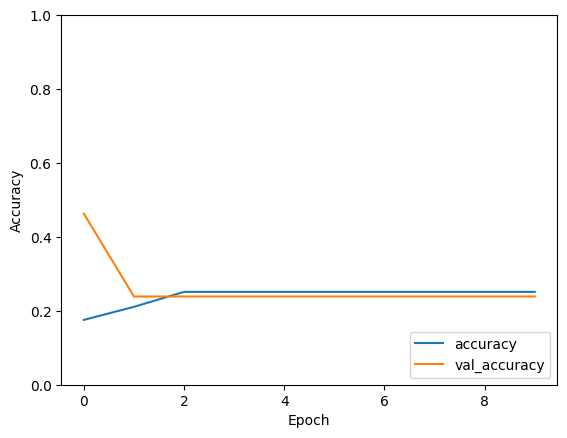

In [33]:
# Train model
tf.random.set_seed(33)
history = model.fit(X_train_re, y_train_re, epochs=10, batch_size=32, validation_data=(X_val_re, y_val_re))

# plot accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [34]:
# evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(test_acc)

69/69 - 1s - loss: nan - accuracy: 0.2475 - 750ms/epoch - 11ms/step
0.24749772250652313
